In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# location to save figures
import os
cwd = os.getcwd()
figure_path = cwd + '/figures/'

# ECO Survey

In [3]:
# load ECO data
from astropy.io import ascii
data_path = '../data/'
data = ascii.read(data_path + "eco_data.csv")  
print(data.dtype.names)

('NAME', 'RADEG', 'DEDEG', 'CZ', 'LOGMSTAR', 'MEANFSMGR', 'ABSRMAG', 'B_A', 'DGR', 'FC', 'FM16', 'MORPHEL', 'LOGMGAS', 'CCR', 'MODELU_RCORR')


## Survey Footprint

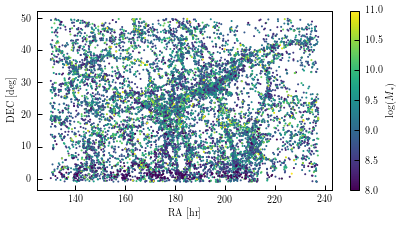

In [4]:
# plot survey

ra = data['RADEG']#/(360.0/24.0) # convert to hours
dec = data['DEDEG']
mstar = data['LOGMSTAR'] #color-code by stellar mass

fig = plt.figure(figsize=(6.6,3.3))
plt.scatter(ra, dec, s=1, c=mstar, vmin=8.0, vmax=11.0)
plt.xlabel(r'${\rm RA}~[{\rm hr}]$')
plt.ylabel(r'${\rm DEC}~[{\rm deg}]$')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\log(M_*)$')
plt.show()

filename = 'eco_survey_footprint.pdf'
fig.savefig(figure_path + filename, dpi=250)

## Survey Volume

In [56]:
# calculate survey volume
from eco_mocks.survey_utils import mc_survey_area

# MC estaimte the area of the ECO survey
area = mc_survey_area(100000, survey='eco_a') # steradians
area_sqdeg = area * (180.0/np.pi)**2  # square degrees
print('The area of ECO is: {0} square degrees.'.format(area_sqdeg))

The area of ECO is: 5753.55050546 square degrees.


In [66]:
# calculate survey volume
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

from astropy.constants import c

zmax = 7000.0/c.to('km/s')
zmin = 2530.0/c.to('km/s')

v0 = cosmo.comoving_volume(zmin.value)
v1 = cosmo.comoving_volume(zmax.value)

volume = (area/(4.0*np.pi))*(v1-v0)
volume = volume.to('Mpc^3').value

print('The volume of ECO is: {0}^3 Mpc'.format(volume**(1/3)))

The volume of ECO is: 81.8118206584^3 Mpc


## Stellar and Baryonic Mass Functions

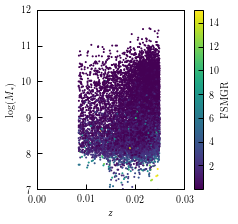

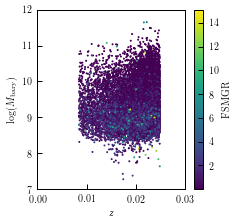

In [67]:
from astropy.constants import c
z = data['CZ']/c.to('km/s')
z = z.value
mstar = np.log10((10**data['LOGMSTAR'])*0.7**2)
mbary = np.log10((10.0**data['LOGMGAS'])*0.7**2 + (10.0**mstar))
fsmgr = data['MEANFSMGR']

fig = plt.figure(figsize=(3.3,3.3))
plt.scatter(z, mstar, s=1, c=fsmgr)
plt.xlabel(r'${\rm RA}~[{\rm hr}]$')
plt.ylabel(r'${\rm DEC}~[{\rm deg}]$')
plt.xlabel(r'$z$')
plt.ylabel(r'$\log(M_*)$')
plt.ylim([7.0,12.0])
plt.xlim([0.0,0.03])
cbar = plt.colorbar()
cbar.ax.set_ylabel('FSMGR')
plt.show()

fig = plt.figure(figsize=(3.3,3.3))
plt.scatter(z, mbary, s=1, c=fsmgr)
plt.xlabel(r'${\rm RA}~[{\rm hr}]$')
plt.ylabel(r'${\rm DEC}~[{\rm deg}]$')
plt.xlabel(r'$z$')
plt.ylabel(r'$\log(M_{\rm bary})$')
plt.ylim([7.0,12.0])
plt.xlim([0.0,0.03])
cbar = plt.colorbar()
cbar.ax.set_ylabel('FSMGR')
plt.show()

In [71]:
mbins = np.arange(7.0,12.0,0.1)

counts_mstar = np.histogram(mstar, bins=mbins, weights=data['CCR'])[0]
counts_mstar = counts_mstar/np.diff(mbins)/volume

counts_mbary = np.histogram(mbary, bins=mbins, weights=data['CCR'])[0]
counts_mbary = counts_mbary/np.diff(mbins)/volume

# load parameterized fits
from eco_mocks.galaxy_abundance_functions import Eckert_2016_phi
msample = np.logspace(6,12,1000)
model_1 = Eckert_2016_phi(sample='ECO SMF double')
model_2 = Eckert_2016_phi(sample='ECO BMF double')

bin_centers = (mbins[:-1]+mbins[1:])/2.0

In [101]:
def bootstrap_histogram(x, bins, weights, Nboot=1000):
    counts = np.zeros((Nboot, len(bins)-1))
    for i in range(0,Nboot):
        inds = np.random.randint(0, high=len(x)-1, size=len(x))
        xx = x[inds]
        ww = weights[inds]
        counts[i,:] = np.histogram(xx, bins=bins, weights=ww)[0]
    
    err = np.std(counts, axis=0)
    counts = np.mean(counts, axis=0)
    
    return counts, err

In [106]:
counts_mstar, counts_mstar_err = bootstrap_histogram(mstar, bins=mbins, weights=data['CCR'])
counts_mstar = counts_mstar/np.diff(mbins)/volume
counts_mstar_err = counts_mstar_err/np.diff(mbins)/volume

counts_mbary, counts_mbary_err = bootstrap_histogram(mbary, bins=mbins, weights=data['CCR'])
counts_mbary = counts_mbary/np.diff(mbins)/volume
counts_mbary_err = counts_mbary_err/np.diff(mbins)/volume

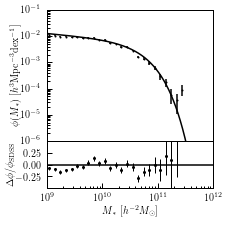

In [107]:
# stellar mass function

fig = plt.figure(figsize=(3.3,3.3))

#upper panel
rect = 0.2,0.35,0.7,0.55
ax = fig.add_axes(rect)
p1 = ax.errorbar(10**bin_centers, counts_mstar, yerr=counts_mstar_err, fmt='o', color='black', ms=2, mec='none')
ax.plot(msample, model_1(msample), '-', color='black')
ax.set_xlim([10**9,10**12])
ax.set_ylim([10**-6,10**-1])
ax.set_yticks([10**-5,10**-4,10**-3,10**-2,10**-1])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$\phi(M_{*})~[h^{3}{\rm Mpc}^{-3}{\rm dex}^{-1}]$', labelpad=-1)
ax.xaxis.set_visible(False)

#lower panel
rect = 0.2,0.15,0.7,0.2
ax = fig.add_axes(rect)
ax.plot([10**5, 10**13], [0.0,0.0], '-', color='black')
ax.errorbar(10**bin_centers, (counts_mstar-model_1(10**bin_centers))/model_1(10**bin_centers), yerr=(counts_mstar_err)/model_1(10**bin_centers), fmt='o', color='black', ms=2, lw=1)
ax.set_ylim([-0.5,0.5])
ax.set_yticks([-0.25,0.0,0.25])
ax.set_xlim([10**9,10**12])
ax.set_xscale('log')
ax.set_ylabel(r'$\Delta\phi/\phi_{\rm SDSS}$', labelpad=-2)
ax.set_xlabel(r'$M_{*} ~[h^{-2}M_{\odot}]$')

plt.show()

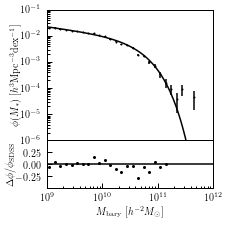

In [108]:
# baryonic mass function

fig = plt.figure(figsize=(3.3,3.3))

#upper panel
rect = 0.2,0.35,0.7,0.55
ax = fig.add_axes(rect)
p1 = ax.errorbar(10**bin_centers, counts_mbary, yerr=counts_mbary_err, fmt='o', color='black', ms=2, mec='none')
ax.plot(msample, model_2(msample), '-', color='black')
ax.set_xlim([10**9,10**12])
ax.set_ylim([10**-6,10**-1])
ax.set_yticks([10**-5,10**-4,10**-3,10**-2,10**-1])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$\phi(M_{*})~[h^{3}{\rm Mpc}^{-3}{\rm dex}^{-1}]$', labelpad=-1)
ax.xaxis.set_visible(False)

#lower panel
rect = 0.2,0.15,0.7,0.2
ax = fig.add_axes(rect)
ax.plot([10**5, 10**13], [0.0,0.0], '-', color='black')
ax.errorbar(10**bin_centers, (counts_mbary-model_2(10**bin_centers))/model_2(10**bin_centers), yerr=(counts_mbary_err)/model_1(bin_centers), fmt='o', color='black', ms=2, lw=1)
ax.set_ylim([-0.5,0.5])
ax.set_yticks([-0.25,0.0,0.25])
ax.set_xlim([10**9,10**12])
ax.set_xscale('log')
ax.set_ylabel(r'$\Delta\phi/\phi_{\rm SDSS}$', labelpad=-2)
ax.set_xlabel(r'$M_{\rm bary} ~[h^{-2}M_{\odot}]$')

plt.show()